In [1]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')
from mi.instrument.kut.ek60.ooicore.zplsc_b import *

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%matplotlib inline

In [3]:
year_all = 2015
month_all = 9
day_all = range(20,31)
month_all = (month_all,) if not isinstance(month_all, (tuple, list)) else month_all
year_all = (year_all,) if not isinstance(year_all, (tuple, list)) else year_all
date_wanted = ['%04d%02d%02d' %(yy,mm,dd) for dd in day_all for mm in month_all for yy in year_all]

In [4]:
date_wanted

['20150920',
 '20150921',
 '20150922',
 '20150923',
 '20150924',
 '20150925',
 '20150926',
 '20150927',
 '20150928',
 '20150929',
 '20150930']

In [5]:
data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
files = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %date_wanted[0]))

In [6]:
files

['/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150920-T000000.raw']

## Load data

In [7]:
particle_data, data_times, power_data_dict, freq, bin_size, config_header, config_transducer = parse_echogram_file(files[0])

2017-10-12 18:06:32,237 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150920-T000000.raw'


In [9]:
cal_params = get_cal_params(power_data_dict,particle_data,config_header,config_transducer)

In [10]:
def get_power_data_mtx(data_dict,frequencies):
    '''
    Convert data_dict to numpy array
    Input:
        data_dict     power_data_dict or Sv from power2Sv()
        frequencies   unpacked dict from parse_echogram_file()
    '''
    fval = frequencies.values()
    fidx = sorted(range(len(fval)), key=lambda k: fval[k])   # get key sequence for low to high freq
    fidx = [x+1 for x in fidx]
    return np.array((data_dict[fidx[0]],\
                     data_dict[fidx[1]],\
                     data_dict[fidx[2]]))  # organize all values into matrix

In [11]:
# Swap sequence of 120 kHz and 38 kHz cal_params and data
cal_params = [cal_params[fn] for fn in [1,0,2]]
power_data = get_power_data_mtx(power_data_dict,freq)

In [12]:
power_data.shape

(3, 1046, 28702)

## Noise estimation and removal

In [16]:
def get_noise(power_data,depth_bin_size,ping_bin_range,depth_bin_range,tvgCorrectionFactor=2):
    '''
    INPUT:
        power_data            2D mtx of power data [depth x ping num]
        ping_bin_range        average over M pings
        depth_bin_range       average over depth_bin_range [m]
        tvgCorrectionFactor   default (=2) is to apply TVG correction with offset of 2 samples
                              note this factor is important in TVG compensation
                              and therefore in how power_bin is obtained as well
    OUTPUT:
        minimum value for bins of averaged ping
    '''
    N = int(np.floor(depth_bin_range/depth_bin_size))
    
    # Average uncompensated power over M pings and N depth bins
    depth_bin_num = int(np.floor((power_data.shape[0]-tvgCorrectionFactor)/N))
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    power_bin = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N)+N*iD+tvgCorrectionFactor  # match the 2-sample offset
            ping_idx = np.arange(ping_bin_range)+ping_bin_range*iP
            power_bin[iD,iP] = np.mean(10**(power_data[np.ix_(depth_idx,ping_idx)]/10))

    # Noise = minimum value for each averaged ping
    return np.min(power_bin,0),ping_bin_num

In [60]:
def remove_noise_new(power_data,cal,noise_est,ping_bin_range=40,tvg_correction_factor=2):
    '''
    Function for noise removal and TVG + absorption compensation
    Ref: De Robertis et al. 2010
    
    INPUT:
        power_data      2D mtx of power data [depth x ping num]
        noise_est       results from `get_noise`
        ping_bin_range          average over M pings
        depth_bin_range         average over depth_bin_range [m]
        tvg_correction_factor   default(=2) for converting power_data to Sv
    OUTPUT:
        Sv_raw       TVG and absorption compensated Sv data, no noise removal
        Sv_corr      TVG and absorption compensated Sv data, no noise removal        
        Sv_noise     TVG and absorption compensated noise estimation
    '''

    # Get cal params
    f = cal['frequency']
    c = cal['soundvelocity']
    t = cal['sampleinterval']
    alpha = cal['absorptioncoefficient']
    G = cal['gain']
    phi = cal['equivalentbeamangle']
    pt = cal['transmitpower']
    tau = cal['pulselength']

    # key derived params
    dR = c*t/2   # sample thickness
    wvlen = c/f  # wavelength

    # Calc gains
    CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

    # calculate Sa Correction
    idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
    Sac = 2 * cal['sacorrectiontable'][idx]

    # Get TVG
    range_vec = np.arange(power_data.shape[0]) * dR
    rangeCorrected = range_vec - (tvg_correction_factor * dR)
    rangeCorrected[rangeCorrected<0] = 0

    TVG = np.empty(rangeCorrected.shape)
    TVG[rangeCorrected!=0] = \
        np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
    TVG[rangeCorrected==0] = 0

    # Get absorption
    ABS = 2*alpha*rangeCorrected

    # Compensate measurement for noise and corrected for transmission loss
    # also estimate Sv_noise component for subsequent SNR check

    # Noise removal
    if noise_est.shape==():  # if noise_est is single element
        subtract = 10**(power_data/10)-noise_est
        tmp = 10*np.log10(np.ma.masked_less_equal(subtract,0))
        tmp.set_fill_value(-999)
        Sv_corr = (tmp.T+TVG+ABS-CSv-Sac).T
        Sv_noise = 10*np.log10(noise_est)+TVG+ABS-CSv-Sac

    else:
        ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
        Sv_corr = np.ma.empty(power_data.shape)   # log domain corrected Sv
        Sv_noise = np.empty(power_data.shape)  # Sv_noise
        for iP in range(ping_bin_num):
            ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
            subtract = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
            tmp = 10*np.log10(np.ma.masked_less_equal(subtract,0))
            tmp.set_fill_value(-999)
            Sv_corr[:,ping_idx] = (tmp.T +TVG+ABS-CSv-Sac).T
            Sv_noise[:,ping_idx] = np.array([10*np.log10(noise_est[iP])+TVG+ABS-CSv-Sac]*ping_bin_range).T
    
    # Raw Sv withour noise removal but with TVG/absorption compensation
    Sv_raw = (power_data.T+TVG+ABS-CSv-Sac).T
    
    return Sv_raw,Sv_corr,Sv_noise

In [61]:
# Set param
ping_bin_range = 40
depth_bin_range = 10
depth_bin_size = bin_size
tvg_correction_factor = 2

In [81]:
num_freq = len(power_data)
Sv_raw = np.ma.empty(power_data.shape)
Sv_corr = np.ma.empty(power_data.shape)
Sv_noise = np.ma.empty(power_data.shape[0:2])
for fn in range(num_freq):
    noise,ping_bin_num = get_noise(power_data[fn,:,:],depth_bin_size,ping_bin_range,depth_bin_range)
    Sv_raw[fn,:,:],Sv_corr[fn,:,:],Sv_noise[fn,:] = \
        remove_noise_new(power_data[fn,:,:],cal_params[fn],noise.min(),ping_bin_range,tvg_correction_factor)

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in log10


In [82]:
Sv_raw_o = np.ma.empty(power_data.shape)
Sv_corr_o = np.ma.empty(power_data.shape)
Sv_noise_o = np.ma.empty(power_data.shape)
for fn in range(num_freq):
    noise,ping_bin_num = get_noise(power_data[fn,:,:],depth_bin_size,ping_bin_range,depth_bin_range)
    Sv_raw_o[fn,:,:],Sv_corr_o[fn,:,:],Sv_noise_o[fn,:,:] = \
        remove_noise_new(power_data[fn,:,:],cal_params[fn],noise,ping_bin_range,tvg_correction_factor)

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: invalid value encountered in log10


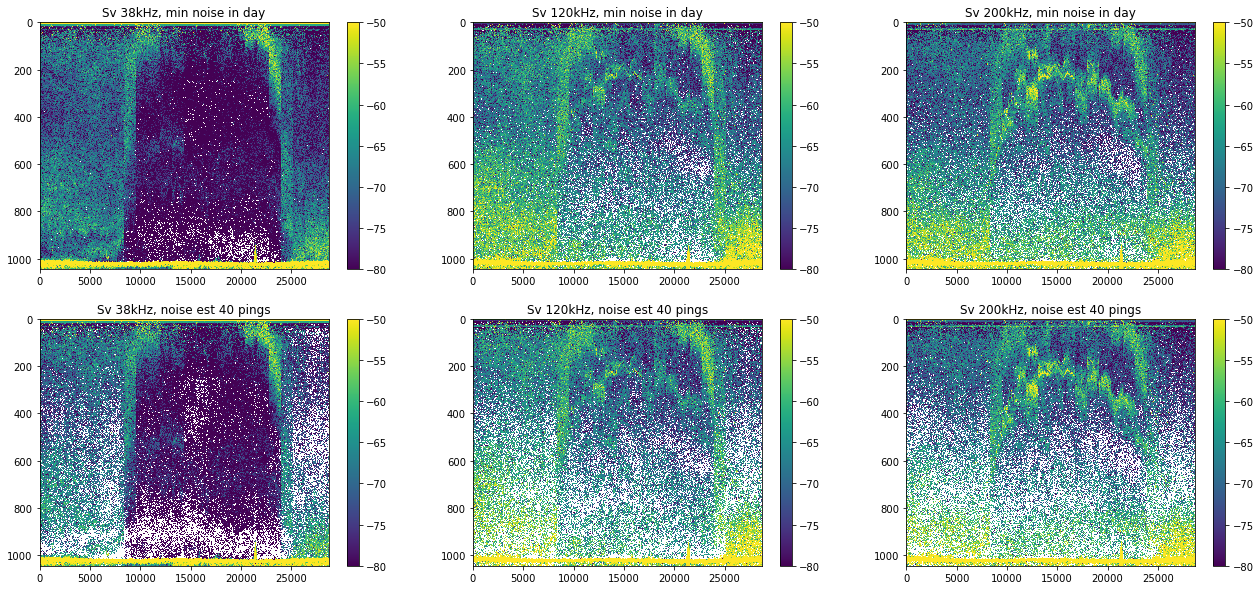

In [92]:
fig,ax = plt.subplots(2,3,figsize=(22,10))
im0 = ax[0,0].imshow(Sv_corr[0,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Sv 38kHz, min noise in day')
im1 = ax[0,1].imshow(Sv_corr[1,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Sv 120kHz, min noise in day')
im2 = ax[0,2].imshow(Sv_corr[2,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[0,2])
ax[0,2].set_title('Sv 200kHz, min noise in day')
im0 = ax[1,0].imshow(Sv_corr_o[0,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im0,ax=ax[1,0])
ax[1,0].set_title('Sv 38kHz, noise est 40 pings')
im1 = ax[1,1].imshow(Sv_corr_o[1,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im1,ax=ax[1,1])
ax[1,1].set_title('Sv 120kHz, noise est 40 pings')
im2 = ax[1,2].imshow(Sv_corr_o[2,:,:],aspect='auto',vmin=-80,vmax=-50)
fig.colorbar(im2,ax=ax[1,2])
ax[1,2].set_title('Sv 200kHz, noise est 40 pings')

## Select data wanted

In [437]:
def find_nearest_time_idx_new(all_timestamp_num,time_wanted,tolerance):
    '''
    Function to find nearest element
    time_wanted is a datetime object
    tolerance is the max tolerance in second allowed between `time_wanted` and `all_timestamp`
    all_timestamp_num is a numerical date object (i.e., output from `date2num`)
    '''
    time_wanted_num = date2num(time_wanted)
    idx = np.searchsorted(all_timestamp_num, time_wanted_num, side="left")
    if idx > 0 and (idx == len(all_timestamp_num) or \
        np.abs(time_wanted_num - all_timestamp_num[idx-1]) < np.abs(time_wanted_num - all_timestamp_num[idx])):
        idx -= 1

    # If interval between the selected index and time wanted > `tolerance` seconds
    sec_diff = dt.timedelta(all_timestamp_num[idx]-time_wanted_num).total_seconds()
    if np.abs(sec_diff)>tolerance:
        return np.nan
    else:
        return idx

In [520]:
dd = dt.datetime.strptime(date_wanted[0],'%Y%m%d')
hour_all = range(24)
min_all = range(20)
sec_all = range(0,60,1)

In [521]:
time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
idx_wanted = [find_nearest_time_idx_new(data_times,tt,2) for tt in time_wanted]

In [522]:
notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

In [523]:
Sv_raw_wanted = np.ma.empty((len(power_data),power_data[1].shape[0],len(time_wanted)))
Sv_corr_wanted = np.ma.empty((len(power_data),power_data[1].shape[0],len(time_wanted)))
Sv_raw_wanted[:,:,notnanidx] = Sv_raw[:,:,notnanidx_in_all]
Sv_corr_wanted[:,:,notnanidx] = Sv_corr[:,:,notnanidx_in_all]

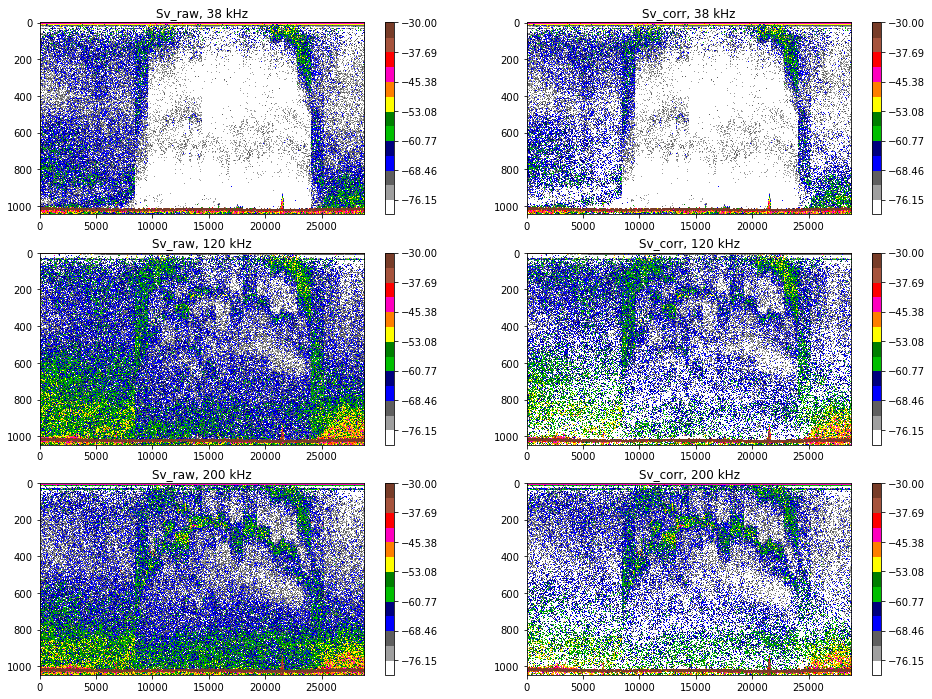

In [535]:
fig,ax = plt.subplots(3,2,figsize=(16,12))
im0 = ax[0,0].imshow(Sv_raw_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Sv_raw, 38 kHz')
im1 = ax[0,1].imshow(Sv_corr_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('Sv_corr, 38 kHz')
im2 = ax[1,0].imshow(Sv_raw_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Sv_raw, 120 kHz')
im3 = ax[1,1].imshow(Sv_corr_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('Sv_corr, 120 kHz')
im4 = ax[2,0].imshow(Sv_raw_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im4,ax=ax[2,0])
ax[2,0].set_title('Sv_raw, 200 kHz')
im5 = ax[2,1].imshow(Sv_corr_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im5,ax=ax[2,1])
ax[2,1].set_title('Sv_corr, 200 kHz')

## Obtain MVBS

In [525]:
def get_MVBS(Sv,depth_bin_size,ping_bin_range,depth_bin_range):
    '''
    Obtain mean MVBS
    
    INPUT:
        th                Sv threshold: discard Sv values below th during averaging
        depth_bin_size    depth bin size from unpacked data
        ping_bin_range    average over M pings
        depth_bin_range   average over depth_bin_range [m]
    OUTPUT:
        smoothed Sv data
    '''

    N = int(np.floor(depth_bin_range/depth_bin_size))  # total number of depth bins
    
    # Average Sv over M pings and N depth bins
    depth_bin_num = int(np.floor(Sv.shape[1]/N))
    ping_bin_num = int(np.floor(Sv.shape[2]/ping_bin_range))
    MVBS = np.ma.empty([Sv.shape[0],depth_bin_num,ping_bin_num])
    for iF in range(Sv.shape[0]):
        for iD in range(depth_bin_num):
            for iP in range(ping_bin_num):
                depth_idx = np.arange(N) + N*iD
                ping_idx = np.arange(ping_bin_range) + ping_bin_range*iP
                MVBS[iF,iD,iP] = 10*np.log10( np.nanmean(10**(Sv[np.ix_((iF,),depth_idx,ping_idx)]/10)) )            
    return MVBS

In [529]:
MVBS = get_MVBS(Sv_corr,depth_bin_size,ping_bin_range,depth_bin_range=2)

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


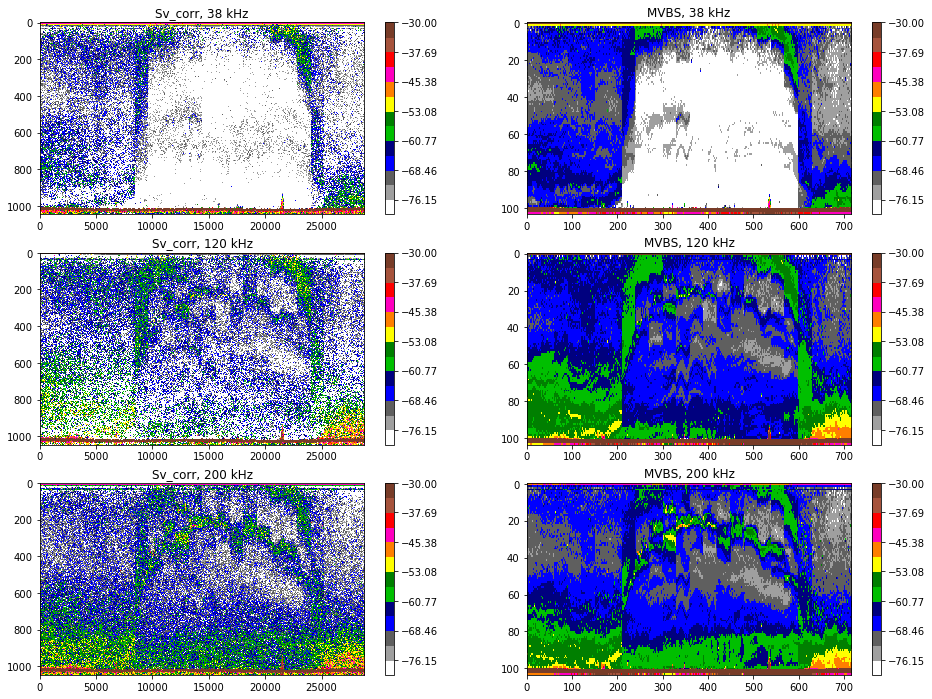

In [534]:
fig,ax = plt.subplots(3,2,figsize=(16,12))
im0 = ax[0,0].imshow(Sv_corr_wanted[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax[0,0])
ax[0,0].set_title('Sv_corr, 38 kHz')
im1 = ax[0,1].imshow(MVBS[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax[0,1])
ax[0,1].set_title('MVBS, 38 kHz')
im2 = ax[1,0].imshow(Sv_corr_wanted[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax[1,0])
ax[1,0].set_title('Sv_corr, 120 kHz')
im3 = ax[1,1].imshow(MVBS[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im3,ax=ax[1,1])
ax[1,1].set_title('MVBS, 120 kHz')
im4 = ax[2,0].imshow(Sv_raw_wanted[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im4,ax=ax[2,0])
ax[2,0].set_title('Sv_corr, 200 kHz')
im5 = ax[2,1].imshow(MVBS[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im5,ax=ax[2,1])
ax[2,1].set_title('MVBS, 200 kHz')

In [531]:
MVBS.shape

(3, 104, 717)

## Freq-differencing

In [539]:
Sv_1 = MVBS[2,:,:]
Sv_2 = MVBS[0,:,:]

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16

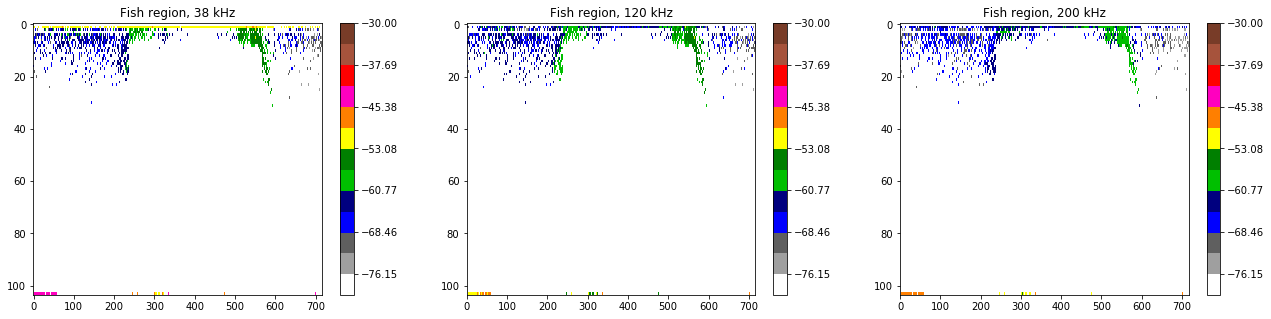

In [545]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

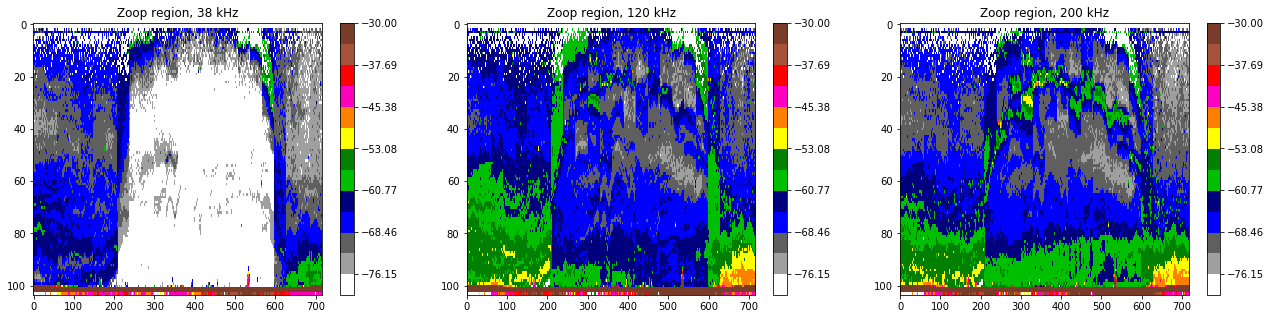

In [543]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')